# Stable Diffusion 3 in KerasHub!

**Author:** [Hongyu Chiu](https://github.com/james77777778), [fchollet](https://twitter.com/fchollet), [lukewood](https://twitter.com/luke_wood_ml), [divamgupta](https://github.com/divamgupta)<br>
**Date created:** 2024/10/09<br>
**Last modified:** 2024/10/24<br>
**Description:** Image generation using KerasHub's Stable Diffusion 3 model.

## Overview

Stable Diffusion 3 is a powerful, open-source latent diffusion model (LDM)
designed to generate high-quality novel images based on text prompts. Released
by [Stability AI](https://stability.ai/), it was pre-trained on 1 billion
images and fine-tuned on 33 million high-quality aesthetic and preference images
, resulting in a greatly improved performance compared to previous version of
Stable Diffusion models.

In this guide, we will explore KerasHub's implementation of the
[Stable Diffusion 3 Medium](https://huggingface.co/stabilityai/stable-diffusion-3-medium)
including text-to-image, image-to-image and inpaint tasks.

To get started, let's install a few dependencies and get images for our demo:

In [1]:
!pip install -Uq keras
!pip install -Uq git+https://github.com/keras-team/keras-hub.git
!wget -O mountain_dog.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
!wget -O mountain_dog_mask.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog_mask.png

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.21.0.dev0 which is incompatible.
--2025-05-26 14:43:34--  https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1187310 (1.1M) [image/png]
Saving to: ‘mountain_dog.png’

mountain_dog.png    100%[=

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import time

import keras
import keras_hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Introduction

Before diving into how latent diffusion models work, let's start by generating
some images using KerasHub's APIs.

To avoid reinitializing variables for different tasks, we'll instantiate and
load the trained `backbone` and `preprocessor` using KerasHub's `from_preset`
factory method. If you only want to perform one task at a time, you can use a
simpler API like this:

```python
text_to_image = keras_hub.models.StableDiffusion3TextToImage.from_preset(
    "stable_diffusion_3_medium", dtype="float16"
)
```

That will automatically load and configure trained `backbone` and `preprocessor`
for you.

Note that in this guide, we'll use `image_shape=(512, 512, 3)` for faster
image generation. For higher-quality output, it's recommended to use the default
size of `1024`. Since the entire backbone has about 3 billion parameters, which
can be challenging to fit into a consumer-level GPU, we set `dtype="float16"` to
reduce the usage of GPU memory -- the officially released weights are also in
float16.

It is also worth noting that the preset "stable_diffusion_3_medium" excludes the
T5XXL text encoder, as it requires significantly more GPU memory. The performace
degradation is negligible in most cases. The weights, including T5XXL, will be
available on KerasHub soon.

In [3]:

def display_generated_images(images):
    """Helper function to display the images from the inputs.

    This function accepts the following input formats:
    - 3D numpy array.
    - 4D numpy array: concatenated horizontally.
    - List of 3D numpy arrays: concatenated horizontally.
    """
    display_image = None
    if isinstance(images, np.ndarray):
        if images.ndim == 3:
            display_image = Image.fromarray(images)
        elif images.ndim == 4:
            concated_images = np.concatenate(list(images), axis=1)
            display_image = Image.fromarray(concated_images)
    elif isinstance(images, list):
        concated_images = np.concatenate(images, axis=1)
        display_image = Image.fromarray(concated_images)

    if display_image is None:
        raise ValueError("Unsupported input format.")

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(display_image)
    plt.show()
    plt.close()


backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(512, 512, 3), dtype="float16"
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)
text_to_image = keras_hub.models.StableDiffusion3TextToImage(backbone, preprocessor)

100%|██████████| 3.12k/3.12k [00:00<00:00, 7.07MB/s]


100%|██████████| 5.57G/5.57G [06:00<00:00, 16.6MB/s]


Next, we give it a prompt:

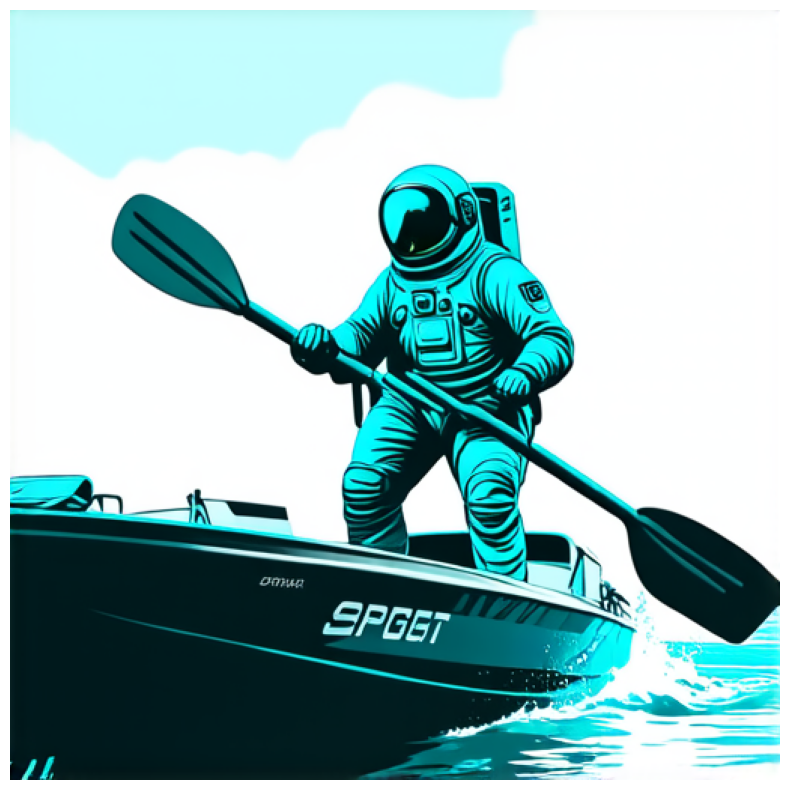

In [5]:
prompt = "Astronaut on a boat paddling, cold color palette, muted colors, detailed, 8k"

# When using JAX or TensorFlow backends, you might experience a significant
# compilation time during the first `generate()` call. The subsequent
# `generate()` call speedup highlights the power of JIT compilation and caching
# in frameworks like JAX and TensorFlow, making them well-suited for
# high-performance deep learning tasks like image generation.
generated_image = text_to_image.generate(prompt)
display_generated_images(generated_image)
